# Data Preparation

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Get the nec
from fastai.vision.all import *
from utils import *
path = untar_data(URLs.PASCAL_2007)

In [3]:
# Read the dataframe containing all the data
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [4]:
# Define the getter for independent variable
def get_x(row): return path/'train'/row['fname']

# Define the getter for dependent variable
def get_y(row): return row['labels'].split(" ")

# Define how to split the data into train and validation
def splitter(df):
    valid_idxs = df[(df.is_valid == True)].index.tolist()
    train_idxs = df[(df.is_valid == False)].index.tolist()
    return (train_idxs, valid_idxs)

In [5]:
# Define a multicategory block with presizing
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(460, min_scale=0.35),
                   batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)]
                  )

In [6]:
dls = dblock.dataloaders(df, bs = 32)

In [7]:
len(dls.train_ds), len(dls.valid_ds)

(2501, 2510)

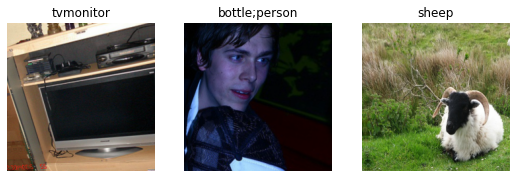

In [8]:
dls.show_batch(nrows=1, ncols=3)

# Model/Loss/Metric Definition

In [9]:
class model(nn.Module):
    def __init__(self, n_classes, arch = resnet50):
        super().__init__()
        self.body = create_body(arch, pretrained = True).to("cuda")
        
        numFeatures = 2 * num_features_model(self.body)
        self.fcClassifiers = []
        
        for idx in range(n_classes):
            self.fcClassifiers.append(nn.Linear(numFeatures, 2))
        self.fcClassifiers = nn.ModuleList(self.fcClassifiers)
    
    def forward(self, inputs):
        bodyOutput = self.body(inputs)
        flattenedBodyOutput = Flatten()(AdaptiveConcatPool2d()(bodyOutput))
        
        fcOutputs = []
        for fcClassifier in self.fcClassifiers:
            fcOutputs.append(fcClassifier(flattenedBodyOutput))
        return fcOutputs

In [10]:
class customLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, inputs, targets):
        finalLoss = 0
        for idx, activation in enumerate(inputs):
            # Get corresponding targets
            targs = targets[:, idx].long()
            loss = F.cross_entropy(activation, targs, reduction = "mean")
            finalLoss += loss
        finalLoss /= targets.shape[1]
        return finalLoss

In [11]:
def customAccuracy(inputs, targets, threshold = 0.5):

    allPredictions = []
    for idx in range(len(inputs)):
        y_preds = (inputs[idx].softmax(dim = 1)[:, 1] > threshold) * 1.
        allPredictions.append(y_preds)
    
    matches = torch.stack(allPredictions, axis = 1) == targets
    accuracy = matches.float().mean()
    return accuracy

In [12]:
mdl = model(dls.c).to("cuda")
loss = customLoss().to("cuda")

# Model Training

In [13]:
learn = Learner(dls, mdl, loss_func = loss, metrics = customAccuracy)

SuggestedLRs(valley=0.0012022644514217973)

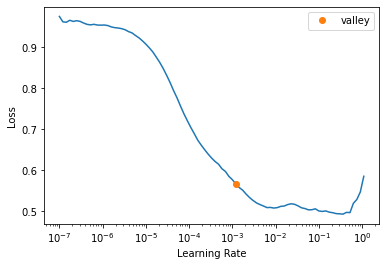

In [14]:
# learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))
learn.lr_find()

In [15]:
learn.fine_tune(epochs = 5, freeze_epochs = 5, base_lr = 5e-4, cbs=SaveModelCallback(fname = "mlcSoftmaxClassification"))

epoch,train_loss,valid_loss,customAccuracy,time
0,0.225611,0.127049,0.956076,01:02
1,0.126275,0.099988,0.963924,01:02
2,0.119167,0.149298,0.950996,01:02
3,0.146600,0.188827,0.941215,01:02
4,0.154291,0.143934,0.952311,01:02


Better model found at epoch 0 with valid_loss value: 0.12704911828041077.
Better model found at epoch 1 with valid_loss value: 0.09998766332864761.


epoch,train_loss,valid_loss,customAccuracy,time
0,0.088754,0.101666,0.965996,01:02
1,0.113213,0.142046,0.952809,01:02
2,0.099484,0.110304,0.962789,01:02
3,0.067891,0.090216,0.969402,01:02
4,0.049167,0.087501,0.969482,01:02


Better model found at epoch 0 with valid_loss value: 0.10166634619235992.
Better model found at epoch 3 with valid_loss value: 0.09021628648042679.
Better model found at epoch 4 with valid_loss value: 0.08750107884407043.


In [12]:
learn = load_learner("mlcClassification.pkl")
learn.dls = dls

# Threshold selection

In [16]:
predictions, targets = learn.get_preds()

In [31]:
predictionsArray = []

for pred in predictions:
    sm_pred = pred.softmax(dim = 1)[:, 1]
    predictionsArray.append(sm_pred)

predictions = torch.stack(predictionsArray, dim = 1)

## Global thresholding

In [34]:
def threshold(preds, targets):
    # Define 100 thresholds equally spaced from 0 to 1
    thresholds = np.arange(0, 1, 0.01)
    
    # Create a mapping from threshold to accuracies
    thresholdAccuracyMapping = {}
    for thresh in thresholds:
        thresholdAccuracyMapping[thresh] = accuracy_multi(preds, targets, thresh = thresh, sigmoid = False).item()
    
    # Create a dataframe out of the above mapping
    df = pd.DataFrame(thresholdAccuracyMapping, index = ["Accuracy"]).T.reset_index()
    df.columns = ["Threshold", "Accuracy"]

    # Make a plot
    fig, ax = plt.subplots(1, 1, figsize = (6, 4))
    sns.lineplot(data = df, x = "Threshold", y = "Accuracy", ax = ax)
    fig.suptitle("Accuracy at different thresholds", fontsize = 24)
    fig.tight_layout();

    # Plot the best threshold
    bestThreshold = df[df.Accuracy == df.Accuracy.max()]
    bestThr = bestThreshold.Threshold.item()
    bestAcc = bestThreshold.Accuracy.item()
    ax.scatter(bestThr, bestAcc, c = "red");

    # Return the best Threshold
    return (bestThr, bestAcc)

(0.72, 0.9711952209472656)

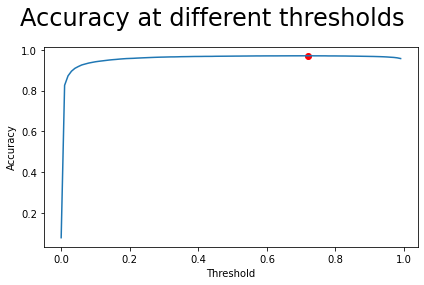

In [35]:
threshold(predictions, targets)

## Local thresholding and then combining

In [36]:
# With max accuracy strategy
utils.getFinalAccuracy(predictions, targets, dls.vocab, "Accuracy")

0.9724103808403015

In [37]:
# With max f1Score strategy
utils.getFinalAccuracy(predictions, targets, dls.vocab, "f1Score")

0.9704382419586182

In [38]:
# With closest point strategy
utils.getFinalAccuracy(predictions, targets, dls.vocab, "Closest")

0.9278286695480347